In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import numpy as np
import plotly.express as px
from sklearn.impute import KNNImputer

In [ ]:
merged_data = pd.read_csv("data/processed/merged_firm_returns.csv")

### Calculate Absolute Ratios

1. <b>Current Ratio</b> : This ratio measures a company's ability to pay off its short-term liabilities with its short-term assets. A higher current ratio indicates a stronger liquidity position.
2. <b>Debt-to-Equity Ratio</b> : This ratio measures the proportion of debt financing to equity financing in a company's capital structure. A higher debt-to-equity ratio indicates a greater reliance on debt financing, which can be a risk factor.
3. <b>Return on Assets (ROA)</b> : This ratio measures the company's ability to generate profits from its assets.
4. <b>Revenue Per Employee</b> : This ratio measures how much revenue a company generates per employee and can be used as a measure of the company's efficiency.
5. <b>Return on Equity (ROE)</b> : This ratio measures the company's ability to generate profits from its shareholders' investments.
6. <b>Asset Turnover Ratio</b> : This ratio measures a company's efficiency in using its assets to generate revenue. A higher asset turnover ratio indicates greater efficiency in asset utilization.
7. <b>Net Income Margin</b> : This ratio measures a company's profitability relative to its revenue. A higher net income margin indicates greater profitability.




In [ ]:
merged_data["Current Ratio"] = (
    merged_data["Total Current Assets"]
    / merged_data["Total Current Liabilities"]
)
merged_data["Debt-to-Equity Ratio"] = (
    merged_data["Total Debt"] / merged_data["Total Equity"]
)
merged_data["Return on Assets"] = (
    merged_data["Net Income - Actual"] / merged_data["Total Assets, Reported"]
)
merged_data["Revenue Per Employee"] = (
    merged_data["Total Revenue"] / merged_data["Company Market Capitalization"]
)
merged_data["Return on Equity"] = (
    merged_data["Net Income - Actual"] / merged_data["Total Equity"]
)
merged_data["Asset Turnover Ratio"] = (
    merged_data["Total Revenue"] / merged_data["Total Assets, Reported"]
)
merged_data["Net Income Margin"] = (
    merged_data["Net Income - Actual"] / merged_data["Total Revenue"]
)

### Outlier Analysis and Treatment

In [ ]:
for i in merged_data.columns:
    box = px.box(merged_data, y=i, width=500, height=500, points="outliers")
    box.show()

In [ ]:
merged_data.columns

In [ ]:
numerical_columns_data = merged_data.copy()
numerical_columns_data.drop(columns=["RIC", "Year", "ESG Score"], inplace=True)

In [36]:
# Calculate the interquartile range (IQR)
Q1 = numerical_columns_data.quantile(0.25)
Q3 = numerical_columns_data.quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Remove outliers from the dataframe
outliers_removed_dataset = numerical_columns_data[
    ~(
        (numerical_columns_data < lower_bound)
        | (numerical_columns_data > upper_bound)
    ).any(axis=1)
]

In [37]:
outliers_removed_dataset.head()

,Total Current Assets,Total Current Liabilities,Total Debt,"Total Assets, Reported",Net Income - Actual,Revenue Per Share,Total Revenue,Total Equity,Total CO2 Equivalent Emissions To Revenues USD in million,Company Market Capitalization,"Property Plant And Equipment, Total - Gross",P/E (Daily Time Series Ratio),returns_yearly,Current Ratio,Debt-to-Equity Ratio,Return on Assets,Revenue Per Employee,Return on Equity,Asset Turnover Ratio,Net Income Margin
6,958.070197,697.413165,877.611125,1972.158125,174.101133,7.841383,1973.676221,321.532669,30.711131,2810.455180,901.445227,17.698577,8.345248,1.373748,2.729462,0.088279,0.702262,0.541473,1.000770,0.088212
7,937.577039,1011.275318,1014.648830,2120.642005,161.302423,7.055922,1857.118761,364.598876,37.880026,1839.323904,1153.222353,13.027894,-22.892890,0.927123,2.782918,0.076063,1.009675,0.442411,0.875734,0.086856
8,766.252729,827.606532,900.748838,2160.779113,186.478624,7.250479,1916.301625,454.527187,35.135417,2906.107284,1256.815229,19.312796,37.406461,0.925866,1.981727,0.086302,0.659405,0.410269,0.886857,0.097312
9,848.120066,910.393705,1001.980250,2293.441726,189.832937,7.380873,1958.883765,491.544855,31.206958,2701.676442,1314.911801,18.140770,0.567951,0.931597,2.038431,0.082772,0.725062,0.386197,0.854124,0.096909
10,768.739248,881.912018,839.886950,2139.837798,204.282041,7.113154,1898.500860,510.444827,33.091915,3187.460578,1131.973458,29.851485,14.370755,0.871673,1.645402,0.095466,0.595615,0.400204,0.887217,0.107602


In [38]:
outliers_removed_dataset = outliers_removed_dataset.merge(
    merged_data[["RIC", "Year", "ESG Score"]],
    left_index=True,
    right_index=True,
    how="inner",
)

In [39]:
outliers_removed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14984 entries, 6 to 24473
Data columns (total 23 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Total Current Assets                                       13579 non-null  float64
 1   Total Current Liabilities                                  13571 non-null  float64
 2   Total Debt                                                 14134 non-null  float64
 3   Total Assets, Reported                                     14171 non-null  float64
 4   Net Income - Actual                                        12671 non-null  float64
 5   Revenue Per Share                                          14161 non-null  float64
 6   Total Revenue                                              14223 non-null  float64
 7   Total Equity                                               14152 non-null  float64
 8   Total 

In [40]:
outliers_removed_dataset.isna().sum() / len(outliers_removed_dataset) * 100

Total Current Assets                                          9.376668
Total Current Liabilities                                     9.430059
Total Debt                                                    5.672718
Total Assets, Reported                                        5.425788
Net Income - Actual                                          15.436466
Revenue Per Share                                             5.492525
Total Revenue                                                 5.078751
Total Equity                                                  5.552589
Total CO2 Equivalent Emissions To Revenues USD in million    49.846503
Company Market Capitalization                                 9.750400
Property Plant And Equipment, Total - Gross                  11.131874
P/E (Daily Time Series Ratio)                                22.176989
returns_yearly                                                0.000000
Current Ratio                                                 9.450080
Debt-t

In [41]:
merged_data.isnull().sum() / len(merged_data) * 100

RIC                                                           0.000000
Total Current Assets                                          7.312390
Total Current Liabilities                                     7.345071
Total Debt                                                    3.476449
Total Assets, Reported                                        3.333470
Net Income - Actual                                          12.810981
Revenue Per Share                                             3.521386
Total Revenue                                                 3.108787
Total Equity                                                  3.427428
Total CO2 Equivalent Emissions To Revenues USD in million    41.141386
ESG Score                                                    27.439846
Company Market Capitalization                                 7.516647
Property Plant And Equipment, Total - Gross                   9.653172
P/E (Daily Time Series Ratio)                                21.933086
Year  

In [ ]:
for i in outliers_removed_dataset.columns:
    box = px.box(
        outliers_removed_dataset, y=i, width=500, height=500, points="outliers"
    )
    box.show()

In [ ]:
outliers_removed_dataset.to_csv(
    "data/processed/without_outliers_dataset.csv", index=False
)

In [ ]:
merged_data.to_csv("data/processed/with_outliers_dataset.csv", index=False)

### Data Imputation & Final Dataset creation for Model Training

#### 1. Without Outliers

Keep rows only where there is a valid ESG Score

In [48]:
without_outliers_clean_data = outliers_removed_dataset[
    outliers_removed_dataset["ESG Score"].notna()
]

In [43]:
subset = list(without_outliers_clean_data.columns)
del subset[-3:]

In [44]:
subset

['Total Current Assets',
 'Total Current Liabilities',
 'Total Debt',
 'Total Assets, Reported',
 'Net Income - Actual',
 'Revenue Per Share',
 'Total Revenue',
 'Total Equity',
 'Total CO2 Equivalent Emissions To Revenues USD in million',
 'Company Market Capitalization',
 'Property Plant And Equipment, Total - Gross',
 'P/E (Daily Time Series Ratio)',
 'returns_yearly',
 'Current Ratio',
 'Debt-to-Equity Ratio',
 'Return on Assets',
 'Revenue Per Employee',
 'Return on Equity',
 'Asset Turnover Ratio',
 'Net Income Margin']

In [49]:
# Define a function to check if at least 80% of values in the subset are null
def check_null_perc(row, subset, null_perc=0.9):
    subset_values = row[subset]
    null_count = subset_values.isna().sum()
    null_perc_subset = null_count / len(subset_values)
    return null_perc_subset >= null_perc

In [50]:
# Apply the function to remove rows where at least 80% of columns in the subset are null
without_outliers_clean_data = without_outliers_clean_data[
    ~without_outliers_clean_data.apply(
        lambda x: check_null_perc(x, subset), axis=1
    )
]

In [51]:
len(outliers_removed_dataset), len(without_outliers_clean_data)

(14984, 9781)

In [56]:
# Normalize the dataset by doing Z score normalization
norm_data_without_outliers = (
    without_outliers_clean_data[subset]
    - without_outliers_clean_data[subset].mean()
) / without_outliers_clean_data[subset].std()

In [58]:
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputed_data_without_outliers = imputer.fit_transform(
    norm_data_without_outliers
)

In [70]:
imputed_without_outliers_df = pd.DataFrame(
    imputed_data_without_outliers,
    columns=list(norm_data_without_outliers.columns),
)

In [71]:
len(imputed_without_outliers_df)

9781

In [72]:
len(without_outliers_clean_data[["RIC", "Year", "ESG Score"]])

9781

In [76]:
imputed_without_outliers_df[
    ["RIC", "Year", "ESG Score"]
] = without_outliers_clean_data[["RIC", "Year", "ESG Score"]].reset_index(
    drop=True
)

In [81]:
imputed_without_outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9781 entries, 0 to 9780
Data columns (total 23 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Total Current Assets                                       9781 non-null   float64
 1   Total Current Liabilities                                  9781 non-null   float64
 2   Total Debt                                                 9781 non-null   float64
 3   Total Assets, Reported                                     9781 non-null   float64
 4   Net Income - Actual                                        9781 non-null   float64
 5   Revenue Per Share                                          9781 non-null   float64
 6   Total Revenue                                              9781 non-null   float64
 7   Total Equity                                               9781 non-null   float64
 8   Total CO

In [78]:
imputed_without_outliers_df.isna().sum()

Total Current Assets                                         0
Total Current Liabilities                                    0
Total Debt                                                   0
Total Assets, Reported                                       0
Net Income - Actual                                          0
Revenue Per Share                                            0
Total Revenue                                                0
Total Equity                                                 0
Total CO2 Equivalent Emissions To Revenues USD in million    0
Company Market Capitalization                                0
Property Plant And Equipment, Total - Gross                  0
P/E (Daily Time Series Ratio)                                0
returns_yearly                                               0
Current Ratio                                                0
Debt-to-Equity Ratio                                         0
Return on Assets                                       

array([[<Axes: title={'center': 'Total Current Assets'}>,
        <Axes: title={'center': 'Total Current Liabilities'}>,
        <Axes: title={'center': 'Total Debt'}>,
        <Axes: title={'center': 'Total Assets, Reported'}>,
        <Axes: title={'center': 'Net Income - Actual'}>],
       [<Axes: title={'center': 'Revenue Per Share'}>,
        <Axes: title={'center': 'Total Revenue'}>,
        <Axes: title={'center': 'Total Equity'}>,
        <Axes: title={'center': 'Total CO2 Equivalent Emissions To Revenues USD in million'}>,
        <Axes: title={'center': 'Company Market Capitalization'}>],
       [<Axes: title={'center': 'Property Plant And Equipment, Total - Gross'}>,
        <Axes: title={'center': 'P/E (Daily Time Series Ratio)'}>,
        <Axes: title={'center': 'returns_yearly'}>,
        <Axes: title={'center': 'Current Ratio'}>,
        <Axes: title={'center': 'Debt-to-Equity Ratio'}>],
       [<Axes: title={'center': 'Return on Assets'}>,
        <Axes: title={'center'

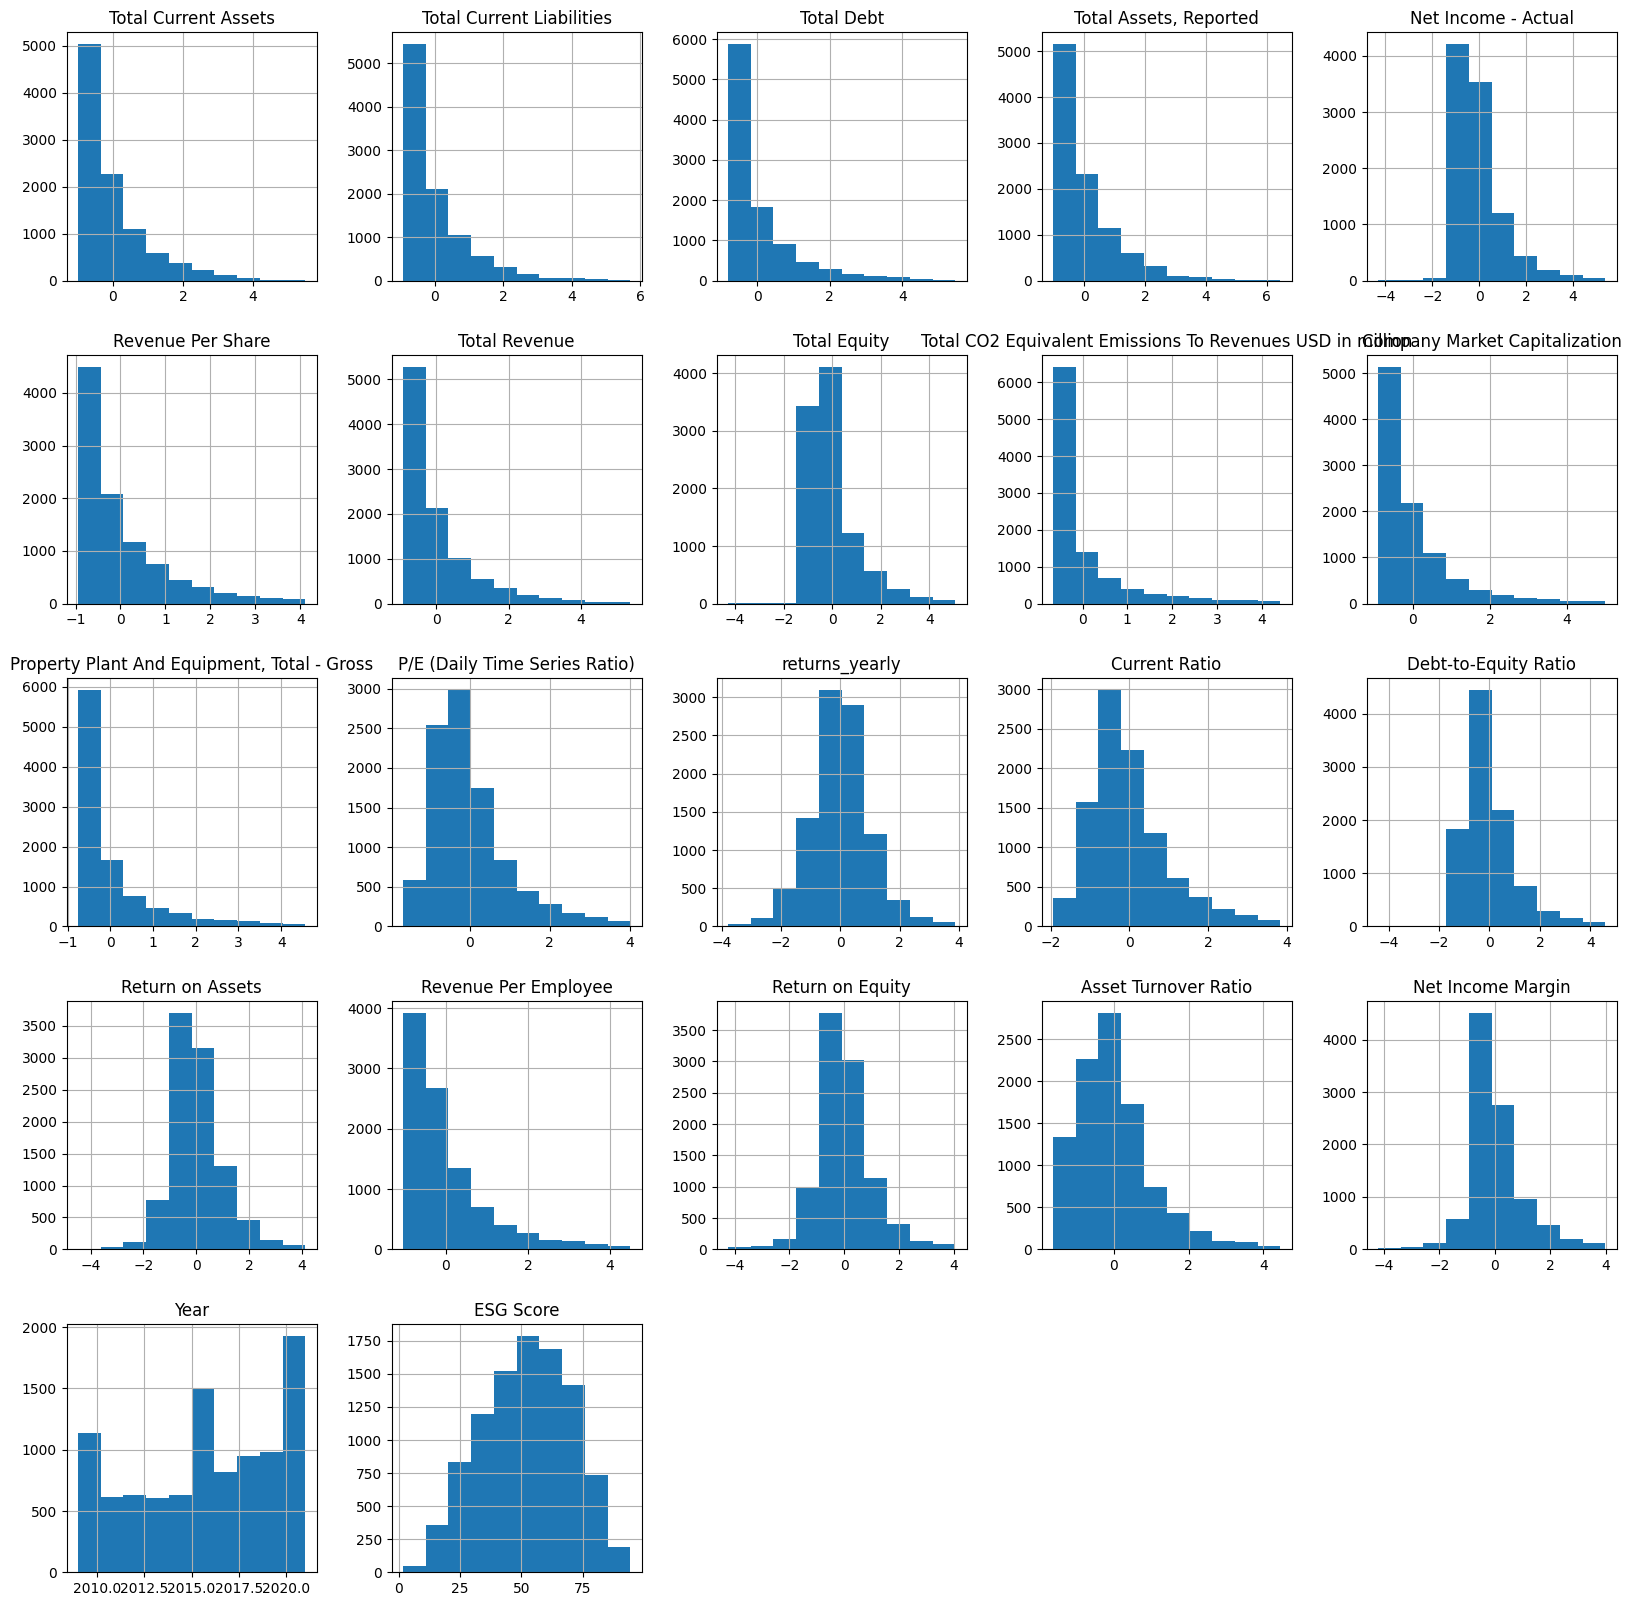

In [80]:
# Plot a histogram

imputed_without_outliers_df.hist(figsize=(20, 20))

In [ ]:
# export merged dataframe

imputed_without_outliers_df.to_csv(
    "data/model_training_files/imputed_without_outliers.csv"
)

#### 2. With Outliers

Keep rows only where there is a valid ESG Score

In [82]:
with_outliers_clean_data = merged_data[
    merged_data["ESG Score"].notna()
]

In [85]:
with_outliers_clean_data.columns

Index(['RIC', 'Total Current Assets', 'Total Current Liabilities',
       'Total Debt', 'Total Assets, Reported', 'Net Income - Actual',
       'Revenue Per Share', 'Total Revenue', 'Total Equity',
       'Total CO2 Equivalent Emissions To Revenues USD in million',
       'ESG Score', 'Company Market Capitalization',
       'Property Plant And Equipment, Total - Gross',
       'P/E (Daily Time Series Ratio)', 'Year', 'returns_yearly',
       'Current Ratio', 'Debt-to-Equity Ratio', 'Return on Assets',
       'Revenue Per Employee', 'Return on Equity', 'Asset Turnover Ratio',
       'Net Income Margin'],
      dtype='object')

In [90]:
subset = list(with_outliers_clean_data.columns)
del subset[0]
del subset[9]
del subset[12]

In [91]:
subset

['Total Current Assets',
 'Total Current Liabilities',
 'Total Debt',
 'Total Assets, Reported',
 'Net Income - Actual',
 'Revenue Per Share',
 'Total Revenue',
 'Total Equity',
 'Total CO2 Equivalent Emissions To Revenues USD in million',
 'Company Market Capitalization',
 'Property Plant And Equipment, Total - Gross',
 'P/E (Daily Time Series Ratio)',
 'returns_yearly',
 'Current Ratio',
 'Debt-to-Equity Ratio',
 'Return on Assets',
 'Revenue Per Employee',
 'Return on Equity',
 'Asset Turnover Ratio',
 'Net Income Margin']

In [92]:
# Define a function to check if at least 80% of values in the subset are null
def check_null_perc(row, subset, null_perc=0.9):
    subset_values = row[subset]
    null_count = subset_values.isna().sum()
    null_perc_subset = null_count / len(subset_values)
    return null_perc_subset >= null_perc

In [93]:
# Apply the function to remove rows where at least 80% of columns in the subset are null
with_outliers_clean_data = with_outliers_clean_data[
    ~with_outliers_clean_data.apply(
        lambda x: check_null_perc(x, subset), axis=1
    )
]

In [94]:
len(merged_data), len(with_outliers_clean_data)

(24479, 17748)

In [101]:
merged_data.shape

(24479, 23)

In [102]:
with_outliers_clean_data.shape

(17748, 23)

In [95]:
# Normalize the dataset by doing Z score normalization
norm_data_with_outliers = (
    with_outliers_clean_data[subset]
    - with_outliers_clean_data[subset].mean()
) / with_outliers_clean_data[subset].std()

In [104]:
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan,keep_empty_features = True)
imputed_data_with_outliers = imputer.fit_transform(
    norm_data_with_outliers
)

In [99]:
norm_data_with_outliers.shape

(17748, 20)

In [105]:
imputed_data_with_outliers.shape

(17748, 20)

In [106]:
imputed_with_outliers_df = pd.DataFrame(
    imputed_data_with_outliers,
    columns=list(norm_data_with_outliers.columns),
)

In [107]:
len(imputed_with_outliers_df)

17748

In [108]:
len(with_outliers_clean_data[["RIC", "Year", "ESG Score"]])

17748

In [109]:
imputed_with_outliers_df[
    ["RIC", "Year", "ESG Score"]
] = with_outliers_clean_data[["RIC", "Year", "ESG Score"]].reset_index(
    drop=True
)

In [110]:
imputed_with_outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17748 entries, 0 to 17747
Data columns (total 23 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Total Current Assets                                       17748 non-null  float64
 1   Total Current Liabilities                                  17748 non-null  float64
 2   Total Debt                                                 17748 non-null  float64
 3   Total Assets, Reported                                     17748 non-null  float64
 4   Net Income - Actual                                        17748 non-null  float64
 5   Revenue Per Share                                          17748 non-null  float64
 6   Total Revenue                                              17748 non-null  float64
 7   Total Equity                                               17748 non-null  float64
 8   Total 

In [111]:
imputed_with_outliers_df.isna().sum()

Total Current Assets                                         0
Total Current Liabilities                                    0
Total Debt                                                   0
Total Assets, Reported                                       0
Net Income - Actual                                          0
Revenue Per Share                                            0
Total Revenue                                                0
Total Equity                                                 0
Total CO2 Equivalent Emissions To Revenues USD in million    0
Company Market Capitalization                                0
Property Plant And Equipment, Total - Gross                  0
P/E (Daily Time Series Ratio)                                0
returns_yearly                                               0
Current Ratio                                                0
Debt-to-Equity Ratio                                         0
Return on Assets                                       

array([[<Axes: title={'center': 'Total Current Assets'}>,
        <Axes: title={'center': 'Total Current Liabilities'}>,
        <Axes: title={'center': 'Total Debt'}>,
        <Axes: title={'center': 'Total Assets, Reported'}>,
        <Axes: title={'center': 'Net Income - Actual'}>],
       [<Axes: title={'center': 'Revenue Per Share'}>,
        <Axes: title={'center': 'Total Revenue'}>,
        <Axes: title={'center': 'Total Equity'}>,
        <Axes: title={'center': 'Total CO2 Equivalent Emissions To Revenues USD in million'}>,
        <Axes: title={'center': 'Company Market Capitalization'}>],
       [<Axes: title={'center': 'Property Plant And Equipment, Total - Gross'}>,
        <Axes: title={'center': 'P/E (Daily Time Series Ratio)'}>,
        <Axes: title={'center': 'returns_yearly'}>,
        <Axes: title={'center': 'Current Ratio'}>,
        <Axes: title={'center': 'Debt-to-Equity Ratio'}>],
       [<Axes: title={'center': 'Return on Assets'}>,
        <Axes: title={'center'

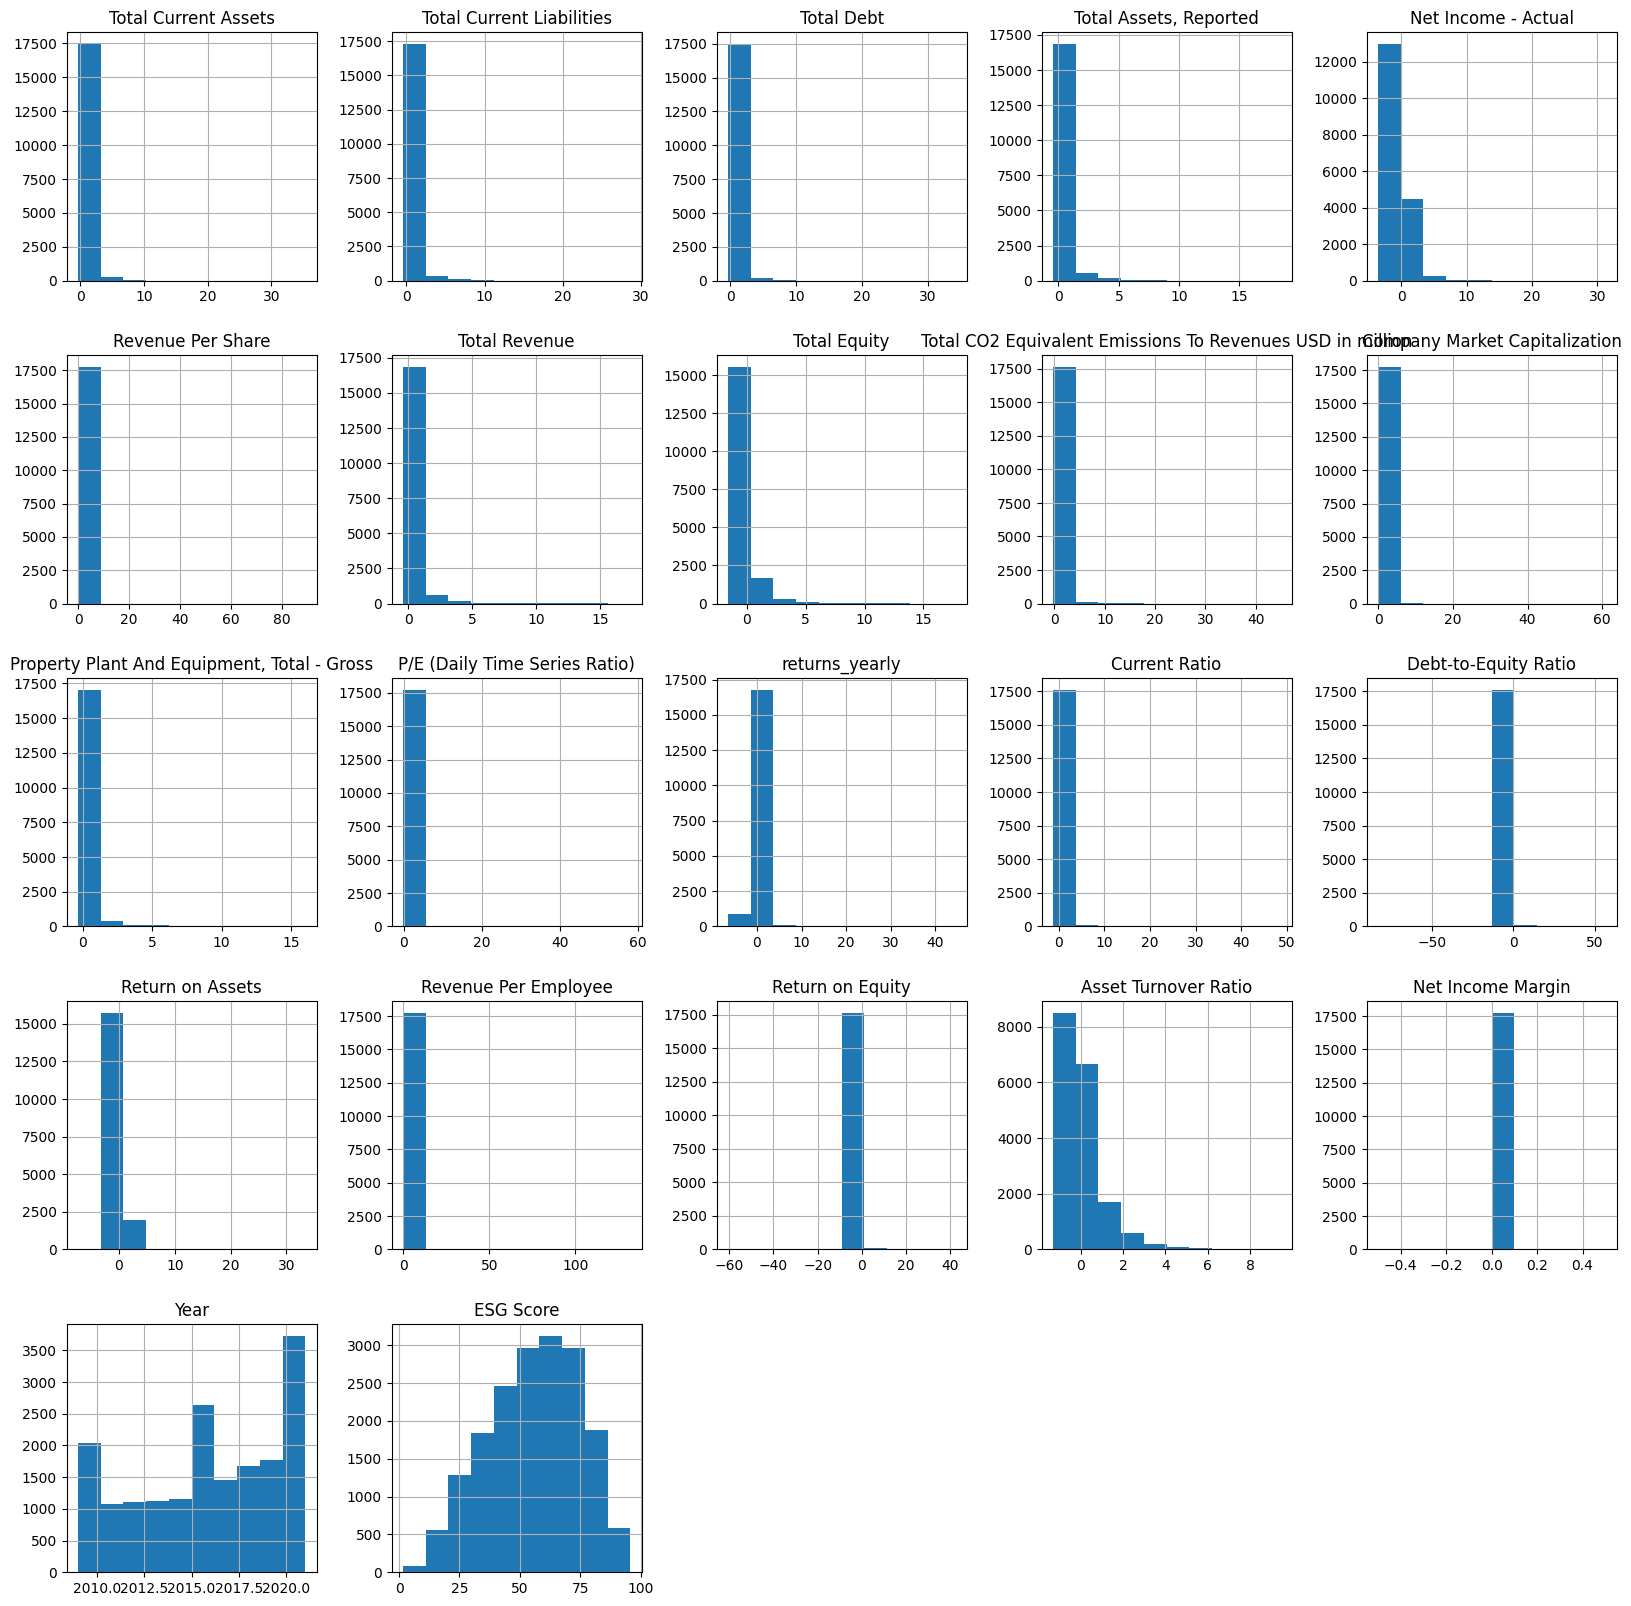

In [112]:
# Plot a histogram

imputed_with_outliers_df.hist(figsize=(20, 20))

In [113]:
# export merged dataframe

imputed_with_outliers_df.to_csv(
    "data/model_training_files/imputed_with_outliers.csv"
)